In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
current_dir = "/Users/thatblue340/Documents/Documents/GitHub/EECS-545-final-project"

# List all files in the current directory (excluding subdirectories)
files_in_dir = [f for f in os.listdir(current_dir)]
for file in files_in_dir:
    print(file)

    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

.DS_Store
train-image
tree-based-models.ipynb
train-metadata.csv
submission.csv
test-image.hdf5
train-image.hdf5
.gitignore
.gitattributes
test-metadata.csv
.git
catboost_info
sample_submission.csv


## Libraries and dependencies

In [3]:
import numpy as np 
import pandas as pd 
import os 
import h5py
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
import plotly.express as px
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error,get_scorer_names
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression,SGDClassifier,BayesianRidge
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import VotingClassifier,StackingClassifier

In [4]:
# Deep learning keras libraries
import keras
print(keras.__version__)
import tensorflow as tf

3.7.0


## Data loading


In [7]:
# current_dir = "/kaggle/input/isic-2024-challenge"
current_dir = "/Users/thatblue340/Documents/Documents/GitHub/EECS-545-final-project"

sample_submission = pd.read_csv(os.path.join(current_dir,'sample_submission.csv'))
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isic_id  3 non-null      object 
 1   target   3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 180.0+ bytes


In [8]:
sample_submission.head()

isic_id  target
0  ISIC_0015657     0.3
1  ISIC_0015729     0.3
2  ISIC_0015740     0.3

In [9]:
train_metadata = pd.read_csv(os.path.join(current_dir,'train-metadata.csv'),low_memory=False)
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [10]:
train_metadata.head()

isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx_5  \
0         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
1  IL_6727506     Benign  Benign     NaN     NaN     NaN     NaN   
2         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
3         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
4         NaN     Benign  Benign     NaN     NaN     NaN     NaN   

   mel_mitotic_index  mel_thick_mm  tbp_lv_dnn_lesion_confidence  
0                NaN           NaN                     97.517282  
1                NaN           NaN                      3.141455  
2                NaN           NaN                     99.804040  
3                NaN           NaN                     99.989998  
4                NaN           NaN                     70.442510  

[5 rows x 55 columns]

In [11]:
test_metadata = pd.read_csv(os.path.join(current_dir,'test-metadata.csv'),low_memory=False)
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [12]:
test_metadata.head()

isic_id  patient_id  age_approx     sex anatom_site_general  \
0  ISIC_0015657  IP_6074337        45.0    male     posterior torso   
1  ISIC_0015729  IP_1664139        35.0  female     lower extremity   
2  ISIC_0015740  IP_7142616        65.0    male     posterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type  tbp_lv_A  \
0                    2.70  TBP tile: close-up        3D: XP  22.80433   
1                    2.52  TBP tile: close-up        3D: XP  16.64867   
2                    3.16  TBP tile: close-up        3D: XP  24.25384   

   tbp_lv_Aext  ...  tbp_lv_radial_color_std_max  tbp_lv_stdL  tbp_lv_stdLExt  \
0    20.007270  ...                     0.304827     1.281532        2.299935   
1     9.657964  ...                     0.000000     1.271940        2.011223   
2    19.937380  ...                     0.230742     1.080308        2.705857   

   tbp_lv_symm_2axis  tbp_lv_symm_2axis_angle   tbp_lv_x     tbp_lv_y  \
0           0.479339                       20 -155.06510  1511.222000   
1           0.426230                       25 -112.36924   629.535889   
2           0.366071                      110  -84.29282  1303.978000   

     tbp_lv_z                                        attribution  \
0  113.980100             Memorial Sloan Kettering Cancer Center   
1  -15.019287  Frazer Institute, The University of Queensland...   
2  -28.576050                                        FNQH Cairns   

   copyright_license  
0              CC-BY  
1              CC-BY  
2              CC-BY  

[3 rows x 44 columns]

#### Load Image Byte String

In this competition, images are provided as byte strings. The following code snippet demonstrates how to load these images into memory. One might wonder why the provided jpeg images aren't being used in the /train-image folder for training. This is because testing images are not provided as JPEG images; instead, they are provided as byte strings. Why use byte strings? They occupy significantly less memory compared to np.array representations.


In [13]:
# image sample visualization
training_validation_hdf5 = h5py.File(f"{current_dir}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{current_dir}/test-image.hdf5", 'r')

Image ISIC_4035791:
Shape:(129, 129, 3)
Image ISIC_2101029:
Shape:(139, 139, 3)


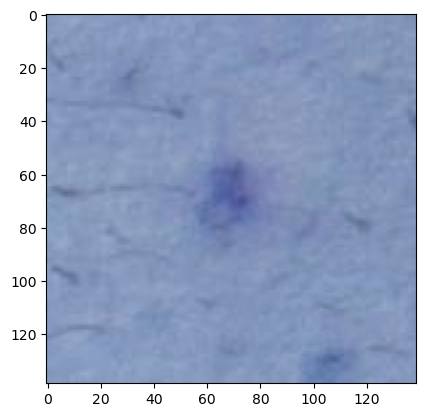

In [14]:
# sample randomly two images from the train dataset
img_sample = train_metadata['isic_id'].sample(n=2).to_list()

# load the image from byte arrays, 
byte_str = [training_validation_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind, val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    # cv2_imshow(val)
    plt.imshow(val)

Image ISIC_0015729:
Shape:(125, 125, 3)
Image ISIC_0015657:
Shape:(141, 141, 3)
Image ISIC_0015740:
Shape:(119, 119, 3)


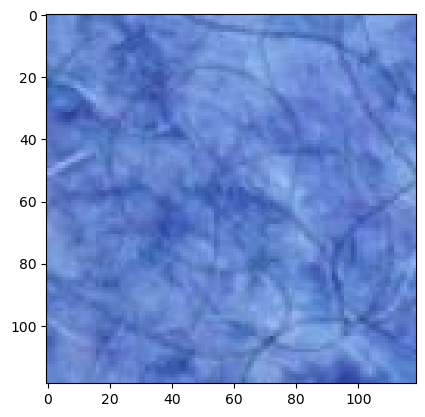

In [15]:
# sample randomly two images from the train dataset
img_sample = test_metadata['isic_id'].sample(n=3).to_list()

# load the image from byte arrays, 
byte_str = [testing_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind,val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    # cv2_imshow(val) 
    plt.imshow(val)

## Preprocessing

In [14]:
class DataPreprocessor:
    def __init__(self):
        self.preprocessor = None
        self.train_columns = None

    def fit_transform(self, df):
        """Preprocess training data and store transformations."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        df = self._drop_train_only_columns(df)
        categorical_cols, numerical_cols = self._identify_column_types(df)
        
        # Define preprocessing pipelines
        numerical_pipeline = Pipeline([
            # ("imputer", SimpleImputer(strategy="median")),
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ])
        
        categorical_pipeline = Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
        
        self.preprocessor = ColumnTransformer([
            ("num", numerical_pipeline, numerical_cols),
            ("cat", categorical_pipeline, categorical_cols)
        ])
        
        transformed_data = self.preprocessor.fit_transform(df)
        
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
        all_columns = numerical_cols + list(cat_feature_names)
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        df_processed["target"] = df["target"].values
        
        self.train_columns = df_processed.columns  # Store train columns
        return df_processed

    def transform(self, df):
        """Preprocess test data using stored transformations from training."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        
        transformed_data = self.preprocessor.transform(df)
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out()
        all_columns = self.train_columns[:-2]  # Exclude 'isic_id' and 'target'
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        # df_processed["target"] = df["target"].values
        
        # Align test dataset with train columns
        df_processed = self._align_train_test_columns(df_processed)
        return df_processed

    def _drop_irrelevant_columns(self, df):
        """Remove unnecessary columns."""
        return df.drop(columns=['patient_id','image_type', 'tbp_tile_type', 'attribution', 'copyright_license'], errors="ignore")

    def _drop_train_only_columns(self,df):
        """Remove columns that are present only in the train set and not in the test set"""
        drop_train_only_columns = [
            'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
            'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'
            ]
        return df.drop(columns=drop_train_only_columns,errors='ignore')
        

    def _identify_column_types(self, df):
        """Identify categorical and numerical columns, excluding 'isic_id' and 'target'."""
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != "isic_id"]
        numerical_cols = [col for col in numerical_cols if col != "target"]
        return categorical_cols, numerical_cols
    
    def _align_train_test_columns(self, df):
        """Ensure test data has the same columns as train data."""
        train_cols = list(self.train_columns)
        train_cols.remove('target')
        missing_cols = set(train_cols) - set(df.columns)
        for col in missing_cols:
            df[col] = 0
        return df[train_cols]


In [15]:
train_metadata = pd.read_csv(os.path.join(current_dir, 'train-metadata.csv'), low_memory=False)
test_metadata = pd.read_csv(os.path.join(current_dir, 'test-metadata.csv'), low_memory=False)

In [16]:
data_object = DataPreprocessor()
train_metadata_processed = data_object.fit_transform(train_metadata)
test_metadata_processed = data_object.transform(test_metadata)

In [17]:
X_train = train_metadata_processed.drop(columns=['target'])
y_train = train_metadata_processed['target']
X_test = test_metadata_processed.copy()


## handling class imbalance

In [18]:
def resampler_data(X, Y):
    
    # Apply undersampling only on numerical data
    resampler = RandomUnderSampler(sampling_strategy=0.1,)
    X_resampled, Y_resampled = resampler.fit_resample(X,Y)
    
    # now apply over sampling for the minorit class
    resampler = RandomOverSampler(sampling_strategy=0.3)
    X_resampled, Y_resampled = resampler.fit_resample(X_resampled, Y_resampled)

    print("X_final shape;",X_resampled.shape)
    print("Y_final shape:",Y_resampled.shape)
    
    return X_resampled, Y_resampled

In [19]:
X_train_final, y_train_final = resampler_data(X_train, y_train)

X_final shape; (5109, 73)
Y_final shape: (5109,)


## metadata only model for submission checking

In [20]:
# Compute class weights
class_weights = y_train_final.value_counts(normalize=True).to_dict()
class_weights = {k: 1/v for k, v in class_weights.items()}
print(class_weights)

{0: 1.2999999999999998, 1: 4.333333333333333}


In [21]:
# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_final.drop(columns=['isic_id'],axis=1), label=y_train_final, weight=[class_weights[y] for y in y_train_final])
# dval = xgb.DMatrix(X_val.drop(columns=['isic_id'],axis=1), label=y_val)

In [22]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': class_weights[1] / class_weights[0],
    'max_depth': 10,
    'eta': 0.01,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'random_state': 63
}

# # Train the XGBoost classifier with cross-validation
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=10000,
#     nfold=5,
#     early_stopping_rounds=10,
#     metrics='logloss',
#     as_pandas=True,
#     seed=42
# )

In [ ]:
# # View the train set results
# print("Cross-validation results:")
# print(cv_results)

In [ ]:
# num_boost_rounds = cv_results['test-logloss-mean'].idxmin()
# xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_rounds)
# print(num_boost_rounds)

In [23]:
# light gbm model
lgb_matrix = lgb.Dataset(X_train_final.drop(columns=['isic_id'],axis=1), label=y_train_final, weight=[class_weights[y] for y in y_train_final])

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'eta': 0.01,
    'num_iterations':10000,
    'num_leaves':63,
    'random_state': 42,
    'verbose':-1
}

In [ ]:
# lgb_model = lgb.train(lgb_params, lgb_matrix, num_boost_round=1000)

In [ ]:
# # CatBoost model
# cb_model = cb.CatBoostClassifier(iterations=10000, depth=6, learning_rate=0.01, loss_function='Logloss', random_seed=42)
# cb_model.fit(X_train_final.drop(columns=['isic_id'],axis=1), y_train_final, sample_weight=[class_weights[y] for y in y_train_final], verbose=0)


In [ ]:
# Predict class probabilities on the test data
dtest = xgb.DMatrix(X_test.drop(columns=['isic_id'],axis=1))
# y_test_pred_proba = model.predict(dtest)
# # Output the predicted probabilities
# print(y_test_pred_proba)

In [ ]:
xgb_pred = lambda X: xgb_model.predict(dtest)
lgb_pred = lambda X: lgb_model.predict(X_test.drop(columns=['isic_id'],axis=1))
cb_pred = lambda X: cb_model.predict_proba(X_test.drop(columns=['isic_id'],axis=1))[:, 1]

In [ ]:
# xgb_pred(dtest)

In [ ]:
# lgb_pred(X_test)

In [ ]:
# cb_pred(X_test)

In [ ]:
# final_pred = np.mean([xgb_pred(dtest),lgb_pred(X_test),cb_pred(X_test)],axis=0)
# final_pred

In [24]:
# Create Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb.XGBClassifier(**params)),
        ('lgb', lgb.LGBMClassifier(**lgb_params)),
        ('cb', cb.CatBoostClassifier(iterations=10000,depth=10, learning_rate=0.01, loss_function='Logloss', random_seed=42))
    ],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',
    verbose=2,
    n_jobs=-1
)

In [25]:
stacking_model.fit(X_train_final.drop(columns=['isic_id'],axis=1), y_train_final)
final_pred = stacking_model.predict_proba(X_test.drop(columns=['isic_id'],axis=1))

0:	learn: 0.6808503	total: 71.2ms	remaining: 11m 52s
1:	learn: 0.6667933	total: 85.7ms	remaining: 7m 8s
2:	learn: 0.6542530	total: 98.9ms	remaining: 5m 29s
3:	learn: 0.6426197	total: 110ms	remaining: 4m 36s
4:	learn: 0.6286571	total: 122ms	remaining: 4m 4s
5:	learn: 0.6174906	total: 135ms	remaining: 3m 45s
6:	learn: 0.6074238	total: 149ms	remaining: 3m 32s
7:	learn: 0.5974367	total: 161ms	remaining: 3m 20s
8:	learn: 0.5860576	total: 173ms	remaining: 3m 11s
9:	learn: 0.5760845	total: 185ms	remaining: 3m 4s
10:	learn: 0.5672174	total: 197ms	remaining: 2m 58s
11:	learn: 0.5573799	total: 208ms	remaining: 2m 52s
12:	learn: 0.5489919	total: 219ms	remaining: 2m 48s
13:	learn: 0.5386144	total: 230ms	remaining: 2m 44s
14:	learn: 0.5304657	total: 244ms	remaining: 2m 42s
15:	learn: 0.5229562	total: 255ms	remaining: 2m 39s
16:	learn: 0.5153916	total: 267ms	remaining: 2m 36s
17:	learn: 0.5078908	total: 281ms	remaining: 2m 35s
18:	learn: 0.5010810	total: 293ms	remaining: 2m 34s
19:	learn: 0.4944509	

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.


0:	learn: 0.6803622	total: 25.3ms	remaining: 4m 13s
0:	learn: 0.6792422	total: 35ms	remaining: 5m 50s
0:	learn: 0.6806921	total: 39.1ms	remaining: 6m 30s
0:	learn: 0.6809815	total: 45.1ms	remaining: 7m 31s
0:	learn: 0.6813289	total: 55.9ms	remaining: 9m 18s
1:	learn: 0.6664547	total: 77.7ms	remaining: 6m 28s
1:	learn: 0.6667118	total: 72.8ms	remaining: 6m 4s
1:	learn: 0.6658269	total: 75.3ms	remaining: 6m 16s
1:	learn: 0.6673327	total: 87.6ms	remaining: 7m 18s
1:	learn: 0.6681717	total: 93.2ms	remaining: 7m 46s
2:	learn: 0.6541602	total: 123ms	remaining: 6m 50s
2:	learn: 0.6544481	total: 125ms	remaining: 6m 57s
2:	learn: 0.6540072	total: 127ms	remaining: 7m 4s
2:	learn: 0.6561875	total: 134ms	remaining: 7m 26s
2:	learn: 0.6554714	total: 136ms	remaining: 7m 33s
3:	learn: 0.6430465	total: 149ms	remaining: 6m 11s
3:	learn: 0.6422089	total: 156ms	remaining: 6m 29s
3:	learn: 0.6418569	total: 174ms	remaining: 7m 15s
4:	learn: 0.6309417	total: 183ms	remaining: 6m 5s
3:	learn: 0.6441816	total:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.


23:	learn: 0.4634242	total: 1.05s	remaining: 7m 16s
22:	learn: 0.4702160	total: 1.07s	remaining: 7m 46s
23:	learn: 0.4587870	total: 1.08s	remaining: 7m 28s
25:	learn: 0.4466706	total: 1.09s	remaining: 6m 57s
24:	learn: 0.4593601	total: 1.08s	remaining: 7m 12s
26:	learn: 0.4403519	total: 1.13s	remaining: 6m 56s
24:	learn: 0.4518704	total: 1.12s	remaining: 7m 27s
25:	learn: 0.4535375	total: 1.12s	remaining: 7m 11s
23:	learn: 0.4629770	total: 1.12s	remaining: 7m 44s
24:	learn: 0.4567154	total: 1.12s	remaining: 7m 27s
25:	learn: 0.4502563	total: 1.15s	remaining: 7m 22s
25:	learn: 0.4451513	total: 1.18s	remaining: 7m 33s
26:	learn: 0.4473962	total: 1.19s	remaining: 7m 18s
24:	learn: 0.4563524	total: 1.18s	remaining: 7m 51s
27:	learn: 0.4331810	total: 1.2s	remaining: 7m 8s
26:	learn: 0.4443044	total: 1.21s	remaining: 7m 26s
26:	learn: 0.4387317	total: 1.24s	remaining: 7m 37s
25:	learn: 0.4493497	total: 1.24s	remaining: 7m 56s
27:	learn: 0.4407976	total: 1.26s	remaining: 7m 29s
27:	learn: 0.4

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.


41:	learn: 0.3589964	total: 2.09s	remaining: 8m 14s
44:	learn: 0.3542214	total: 2.1s	remaining: 7m 44s
41:	learn: 0.3599323	total: 2.11s	remaining: 8m 19s
42:	learn: 0.3630890	total: 2.11s	remaining: 8m 8s
42:	learn: 0.3552152	total: 2.15s	remaining: 8m 17s
45:	learn: 0.3431461	total: 2.15s	remaining: 7m 46s
45:	learn: 0.3506532	total: 2.16s	remaining: 7m 47s
43:	learn: 0.3592474	total: 2.17s	remaining: 8m 10s
42:	learn: 0.3542213	total: 2.17s	remaining: 8m 23s
46:	learn: 0.3466997	total: 2.2s	remaining: 7m 45s
46:	learn: 0.3391520	total: 2.22s	remaining: 7m 49s
43:	learn: 0.3509940	total: 2.22s	remaining: 8m 21s
43:	learn: 0.3508536	total: 2.22s	remaining: 8m 22s
44:	learn: 0.3554195	total: 2.22s	remaining: 8m 10s
44:	learn: 0.3467729	total: 2.26s	remaining: 8m 20s
47:	learn: 0.3353832	total: 2.27s	remaining: 7m 49s
47:	learn: 0.3431487	total: 2.26s	remaining: 7m 48s
45:	learn: 0.3516874	total: 2.26s	remaining: 8m 9s
44:	learn: 0.3466049	total: 2.27s	remaining: 8m 21s
48:	learn: 0.331

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


58:	learn: 0.3048418	total: 2.99s	remaining: 8m 24s
56:	learn: 0.3136402	total: 3.01s	remaining: 8m 45s
60:	learn: 0.2917625	total: 3.03s	remaining: 8m 13s
55:	learn: 0.3054155	total: 3.04s	remaining: 8m 59s
59:	learn: 0.3015202	total: 3.03s	remaining: 8m 21s
55:	learn: 0.3080941	total: 3.04s	remaining: 8m 59s
57:	learn: 0.3101064	total: 3.05s	remaining: 8m 43s
61:	learn: 0.2891208	total: 3.06s	remaining: 8m 10s
56:	learn: 0.3026795	total: 3.07s	remaining: 8m 55s
60:	learn: 0.2980875	total: 3.06s	remaining: 8m 18s
56:	learn: 0.3043364	total: 3.07s	remaining: 8m 56s
58:	learn: 0.3067729	total: 3.09s	remaining: 8m 40s
62:	learn: 0.2862402	total: 3.1s	remaining: 8m 8s
57:	learn: 0.2987128	total: 3.11s	remaining: 8m 52s
57:	learn: 0.3009227	total: 3.11s	remaining: 8m 53s
61:	learn: 0.2949583	total: 3.11s	remaining: 8m 18s
59:	learn: 0.3036818	total: 3.12s	remaining: 8m 37s
63:	learn: 0.2833886	total: 3.13s	remaining: 8m 5s
58:	learn: 0.2955985	total: 3.14s	remaining: 8m 49s
58:	learn: 0.29

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min


6838:	learn: 0.0015236	total: 4m 30s	remaining: 2m 5s
7040:	learn: 0.0015624	total: 4m 30s	remaining: 1m 53s
6813:	learn: 0.0013439	total: 4m 30s	remaining: 2m 6s
6503:	learn: 0.0013899	total: 4m 30s	remaining: 2m 25s
6657:	learn: 0.0014634	total: 4m 30s	remaining: 2m 15s
6839:	learn: 0.0015236	total: 4m 30s	remaining: 2m 5s
7041:	learn: 0.0015624	total: 4m 30s	remaining: 1m 53s
6814:	learn: 0.0013439	total: 4m 30s	remaining: 2m 6s
6504:	learn: 0.0013899	total: 4m 30s	remaining: 2m 25s
6658:	learn: 0.0014629	total: 4m 30s	remaining: 2m 15s
6815:	learn: 0.0013439	total: 4m 30s	remaining: 2m 6s
6840:	learn: 0.0015230	total: 4m 30s	remaining: 2m 5s
7042:	learn: 0.0015624	total: 4m 30s	remaining: 1m 53s
6505:	learn: 0.0013899	total: 4m 30s	remaining: 2m 25s
6659:	learn: 0.0014629	total: 4m 30s	remaining: 2m 15s
7043:	learn: 0.0015624	total: 4m 30s	remaining: 1m 53s
6841:	learn: 0.0015230	total: 4m 30s	remaining: 2m 5s
6816:	learn: 0.0013439	total: 4m 30s	remaining: 2m 6s
6506:	learn: 0.001

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


8944:	learn: 0.0015027	total: 5m 34s	remaining: 39.4s
8702:	learn: 0.0013551	total: 5m 34s	remaining: 49.9s
8285:	learn: 0.0013479	total: 5m 34s	remaining: 1m 9s
8647:	learn: 0.0011764	total: 5m 34s	remaining: 52.3s
8477:	learn: 0.0012392	total: 5m 34s	remaining: 1m
8945:	learn: 0.0015027	total: 5m 34s	remaining: 39.4s
8703:	learn: 0.0013551	total: 5m 34s	remaining: 49.8s
8648:	learn: 0.0011763	total: 5m 34s	remaining: 52.3s
8286:	learn: 0.0013479	total: 5m 34s	remaining: 1m 9s
8478:	learn: 0.0012392	total: 5m 34s	remaining: 1m
8946:	learn: 0.0015027	total: 5m 34s	remaining: 39.3s
8704:	learn: 0.0013551	total: 5m 34s	remaining: 49.8s
8649:	learn: 0.0011763	total: 5m 34s	remaining: 52.2s
8287:	learn: 0.0013479	total: 5m 34s	remaining: 1m 9s
8479:	learn: 0.0012392	total: 5m 34s	remaining: 60s
8947:	learn: 0.0015027	total: 5m 34s	remaining: 39.3s
8705:	learn: 0.0013551	total: 5m 34s	remaining: 49.7s
8650:	learn: 0.0011763	total: 5m 34s	remaining: 52.2s
8480:	learn: 0.0012392	total: 5m 34s

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.3min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


In [26]:
final_pred = final_pred[:,1]
final_pred

array([0.00418485, 0.00407966, 0.00415973])

In [27]:
sub_df = pd.concat([X_test['isic_id'],pd.Series(final_pred)],axis=1)
sub_df.head()

isic_id         0
0  ISIC_0015657  0.004185
1  ISIC_0015729  0.004080
2  ISIC_0015740  0.004160

In [28]:
sub_df.to_csv('submission.csv', index=False)

# Improvements
- use a CNN-extracted feature as input for the random forest

## First we Load the pretrained resNet Model

In [29]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove final classification layer
resnet.eval()  # Set model to evaluation mode

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/thatblue340/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.1MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## 2. Image processing for resNet

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ResNet normalization
])

In [39]:
from PIL import Image

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = resnet(image)
    return features.squeeze().numpy()

## 3. Extract features for dataset
- we apply extract_features function to all the images
- load the labels using pandas
- store them as numpy array

In [40]:
import os
import pandas as pd

In [41]:
# Load metadata
metadata_path = "/Users/thatblue340/Documents/GitHub/EECS-545-final-project/train-metadata.csv"  # Update path
metadata_df = pd.read_csv(metadata_path)

# Create a mapping from isic_id to target (binary class: 0 = benign, 1 = malignant)
id_to_label = dict(zip(metadata_df["isic_id"], metadata_df["target"]))

# Function to get the label given an image filename (assuming filename follows 'isic_id.jpg')
def get_label(image_filename):
    isic_id = image_filename.split('.')[0]  # Extract ID from filename
    return id_to_label.get(isic_id, None)  # Return label (0 or 1), None if not found


/var/folders/4w/dhmdb97x63lfq799n_46pwc80000gn/T/ipykernel_12183/2544101253.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(metadata_path)


In [44]:
from tqdm import tqdm
image_dir = "/Users/thatblue340/Documents/GitHub/EECS-545-final-project/train-image/image"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
features = []
labels = []  # Assuming you have labels for training

# print(len(image_files))

for img in tqdm(image_files, desc="Extracting Features", unit="image"):
    feature_vector = extract_features(os.path.join(image_dir, img))  # Extract CNN features
    features.append(feature_vector)
    labels.append(get_label(img))  # Get label from metadata


# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels  # Append labels

Extracting Features: 100%|██████████| 401059/401059 [3:02:54<00:00, 36.54image/s]  


## 4. Train the random forest model on extracted features
- we use the extracted features from the resNet as input for the random forest classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Prepare dataset
X = features_df.drop(columns=['label'])  # Features
y = features_df['label']  # Labels

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate on test set
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.9989


## Evaluate
- Confusion matrix
- Classification report
- ROC curve

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns


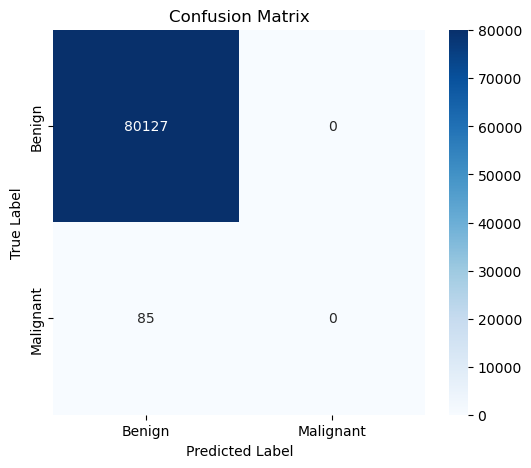

In [47]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [48]:
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     80127
   Malignant       0.00      0.00      0.00        85

    accuracy                           1.00     80212
   macro avg       0.50      0.50      0.50     80212
weighted avg       1.00      1.00      1.00     80212



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)  # Probability of class 1
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()